# __Balance Trees__



We will introduce the concept of balances here.  Balances were originally introduced in the geological sciences with the introduction of the isometric log ratio (ilr) transform.  Here we will refer to the visualizations representing balances as Balance Trees.

Balances are an alternative way to interpret relative abundance information, without worrying about dependency properties between features inherient in multinomial distributions.  Often times, we cannot count all of the individuals within a community, and we are stuck analyzing representative samples.  If we have a community of 2 species, we can visualize the ratio or *balance* between these two species.  Below is a more intuitive explanation of a balance.

<img src="images/Slide1.jpg">

Here we have two species, Red and Green that have equal counts.  The balance is taken as the log ratio between them.  In our convention, we will always take the ratio of the left species over the right species.  So in this case the balance is calculated as:

$$\log \frac{Red}{Green} = \log \frac{5}{5} = \log 1 = 0$$

If the number of red individuals outnumber the number of green individuals 5 to 1, you'll end up with a positive balance of:

$$\log \frac{Red}{Green} = \log \frac{5}{1} = \log 5$$

<img src="images/Slide2.jpg">

Likewise, if the number of green individuals outnumber the number of red individuals 5 to 1, you'll end up with a negative balance of

$$\log \frac{Red}{Green} = \log \frac{1}{5} = - \log 5$$

<img src="images/Slide3.jpg">

Now, this scheme of balances can be generalized to any arbituary bifurcating trees.  But rather than comparing species abundances, we would be comparing mean log abundances of entire subtrees.  We'll refer to the concept of visualizing balances on bifurcating trees as __Balance Trees__. This concept has come under several names, such as sequential binary partitions, or CoDa dendrograms in the geological sciences.

Below is how we would make this calculation on a tree with 4 leaves.

<img src="images/Slide4.jpg">

The full equation on how to estimate balances is as follows
$$
b_i = \sqrt{\frac{l_i r_i}{l_i + r_i}} 
 \log \big( \frac{(\prod_{x_n \in L}{x_n})^{1/l_i}}
 {(\prod_{x_m \in R}{x_m})^{1/r_i}} \big)
$$

where $b_i$ is the $i$th balance, $l_i$ is the number of leaves in the left subtree, $r_i$ is the number of leaves in the right subtree  $x_n$ are the abundances of the species in the left subtree, and $x_m$ are the abundances of species in the right subtree.


In [1]:
from __future__ import division
import numpy as np
import pandas as pd
from skbio.stats.composition import ilr
from skbio import TreeNode
from gneiss.balances import balanceplot, balance_basis
from gneiss.layouts import barchart_layout
import scipy
from functools import partial
from ete3 import Tree, TreeStyle, faces, AttrFace, BarChartFace, CircleFace
%matplotlib inline

To illustrate how to use these modules, consider the following tree

In [2]:
tree = TreeNode.read([u"((a,b)e, (c,d)f)r;"])
print(tree.ascii_art())

                    /-a
          /e-------|
         |          \-b
-r-------|
         |          /-c
          \f-------|
                    \-d


And consider the following abundances for the given sample

In [3]:
table = pd.Series([10, 20, 10, 10],
                  index=['a','b','c','d'])

Given this data, we can visualize the ratios between the abundances according to this tree.
Here, we will be visualizing the log ratios between b/a, d/c and f/e


In [4]:
basis, nodes = balance_basis(tree)
ilr_coords = ilr(table, basis=basis)

Now, we can visualize these log ratios as balances on the tree.  Since the c, d have the same abundances, their ratio is 1, and their log ratio is zero. So that balance on the c,d subtree is zero.

On the other hand, the abundance of b is double the abundance of a.  So the ratio of b/a is 2, making the log ratio log(2). 

The logratios of subtrees can be visualized as balances on the tree as shown below.  In this scenario, the left subtree is on the bottom, and the right subtree is on the top.

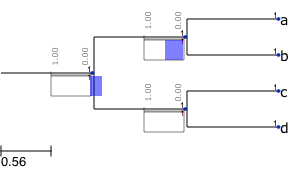

In [5]:
tr, ts = balanceplot(ilr_coords, tree, mode='r', layout=barchart_layout) 
ts.branch_vertical_margin = 20  # adjust the spacing between leaves.
tr.render(file_name='%%inline', tree_style=ts)

The cool thing about these sorts of plots is statistical tests can be run on the directly on the balances.  

For example, below, we have a table of 6 samples $s1$, $s2$, $s3$, $s4$, $s5$, $s6$ and 7 features $a$, $b$, $d$, $f$, $h$, $j$, $l$, which are related with a given tree.  Suppose that samples $s1$, $s2$, $s3$ are within a control group, and samples $s4$, $s5$, $s6$ are within a treatment group.  We would like to see if there is a difference between the sample and treatment groups. 
We can do this by running ANOVAs on each balance, and visualize the p-values on each internal node.  

In [6]:
table = pd.DataFrame([
            [10, 11, 10, 10, 10, 10, 10],
            [10, 12, 11, 11, 11, 11, 13],
            [11, 11, 10, 10, 10, 10, 10],
            [20, 21, 10, 10, 10, 10, 10],
            [20, 21, 10, 10, 10, 10, 10],
            [21, 21, 10, 9,  10, 11, 12]],
            index=['s1', 's2', 's3', 's4', 's5', 's6'],
            columns=['a', 'b', 'd', 'f', 'h', 'j', 'l'])
cats = pd.Series(['Control', 'Control', 'Control', 
                  'Treatment', 'Treatment', 'Treatment'],
                index=['s1', 's2', 's3', 's4', 's5', 's6'])
tree = TreeNode.read([u"((((a,b)5, (f, d)6)3, (h, j)4)2, l)1;"])
table

,a,b,d,f,h,j,l
s1,10,11,10,10,10,10,10
s2,10,12,11,11,11,11,13
s3,11,11,10,10,10,10,10
s4,20,21,10,10,10,10,10
s5,20,21,10,10,10,10,10
s6,21,21,10,9,10,11,12


The tree is structure as shown below.

In [7]:
print(tree.ascii_art())

                                        /-a
                              /5-------|
                             |          \-b
                    /3-------|
                   |         |          /-f
                   |          \6-------|
          /2-------|                    \-d
         |         |
         |         |          /-h
-1-------|          \4-------|
         |                    \-j
         |
          \-l


As before, we can transform these abundances into log ratios as follows

In [8]:
basis, nodes = balance_basis(tree)
balances = ilr(table.values, basis=basis)

And we can calculate ANOVAs on each balance, by splitting up the balances by the control and treatment groups.

In [9]:
pvalues = []
for b in range(balances.shape[1]):
    groups = [balances[(cats == x).values, b] for x in set(cats)]
    f, p = scipy.stats.f_oneway(*groups)
    pvalues.append(-np.log(p))

And now we can plot the balances on the tree.  As expected, the only difference is in the balance with a,b vs f,d.
The effect of that balance diminishes on higher levels of the tree.

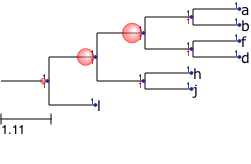

In [10]:
tr, ts = balanceplot(pvalues, tree, mode='r') 
tr.render(file_name='%%inline', tree_style=ts)

There is one thing to be wary about when using this module.  Since each balance is being calculated using log ratios,
there can be no zeros in the original table.  This means that the zeros will need to be removed.  One approach is to add pseudocounts to
all of the values.  The most common pseudocount to add is *1*.  There are many other approaches such as collapsing leaves.

In conclusion, balance trees can be alternative, yet powerful approach at analyzing the community structure of a population.